# RQ1: Does Inhaling Civet Improve Performance Compared to Control?

### Objective

In this notebook we focus solely on Research Question 3: **Does inhaling a Civet scent (channel = 3) improve performance in seated bicep curls compared to a no-scent control (channel = 4)?**

We extract key performance metrics from exercise recordings and user baseline data:

- **normalised Maximum Muscle Contraction:** For each repetition, the maximum pressure is normalised to the user’s baseline pressure (from the users file) and then averaged.
- **Average Time Under Tension (TUT):** The average contraction duration per repetition.
- **Heart Rate Recovery:** Difference between the average heart rate during exercise and after exercise.

This analysis compares paired measurements for the same individuals under Civet and control conditions using a suite of methods and visualisations that include:

- **Paired Data visualisation:** Paired line plots, density plots of differences, and Bland–Altman plots.
- **Statistical Testing:** Paired t–test, Wilcoxon signed–rank test, effect size (Cohen’s d), and bootstrap confidence intervals.
- **Multivariate Analysis:** MANOVA on the vector of differences across performance metrics.

This notebook is intended to provide a high–level statistical assessment of RQ3.


## 1. Data Loading and Preprocessing

We load the users and exercise recordings data (newline-delimited JSON files), merge them by matching the `userEmail` field from exercise recordings with the `email` field from users, and compute our performance metrics. Note that our key metrics are computed as follows:

- **Normalised Max Pressure:** For each rep, $\frac{\text{rep maxPressure}}{\text{base pressure}} \times 100\%$ then averaged.
- **Average TUT:** Mean of the "tut" values across reps.
- **HR Recovery:** Difference between the average heart rate during the exercise and the average post-exercise heart rate.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.multivariate.manova import MANOVA

# Set plot style
sns.set(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (10, 6)

### Load Users Data
users_file = 'users_2025-04-13_12-38-11.json'
with open(users_file, 'r') as f:
    users_lines = f.readlines()
users_df = pd.DataFrame([json.loads(line) for line in users_lines])

### Load Exercise Recordings Data
exercise_file = 'exercise_recordings_2025-04-13_12-38-11.json'
with open(exercise_file, 'r') as f:
    exercise_lines = f.readlines()
exercise_df = pd.DataFrame([json.loads(line) for line in exercise_lines])

# Convert key identifiers to string
exercise_df['userEmail'] = exercise_df['userEmail'].astype(str)
users_df['email'] = users_df['email'].astype(str)

# Merge datasets on user identifier
data = exercise_df.merge(users_df[['email', 'pressure']], left_on='userEmail', right_on='email', how='left')
data.rename(columns={'pressure': 'base_pressure'}, inplace=True)
print('Merged data shape:', data.shape)

### Define helper functions to compute performance metrics
def compute_accelerometer_metrics(accel_data, base_press):
    """
    Compute the average TUT and normalised max pressure for a given set of repetitions.
    normalised pressure per rep = (rep maxPressure / base_press) * 100.
    """
    if not accel_data:
        return pd.Series({'avg_tut': np.nan, 'avg_norm_pressure': np.nan})
    tut_vals = []
    norm_press_vals = []
    for rep in accel_data:
        try:
            tut = float(rep.get('tut', np.nan))
        except (ValueError, TypeError):
            tut = np.nan
        try:
            rep_pressure = float(rep.get('maxPressure', np.nan))
        except (ValueError, TypeError):
            rep_pressure = np.nan
        tut_vals.append(tut)
        if base_press and base_press > 0:
            norm_press_vals.append((rep_pressure / base_press) * 100)
        else:
            norm_press_vals.append(np.nan)
    return pd.Series({
        'avg_tut': np.nanmean(tut_vals),
        'avg_norm_pressure': np.nanmean(norm_press_vals)
    })

def compute_hr_average(hr_list):
    """
    Compute the average heart rate from a list of heart rate recordings.
    """
    if not hr_list:
        return np.nan
    hr_vals = []
    for item in hr_list:
        try:
            hr_vals.append(float(item.get('hr', np.nan)))
        except (ValueError, TypeError):
            hr_vals.append(np.nan)
    return np.nanmean(hr_vals)

# Apply helper functions
accel_metrics = data.apply(lambda row: compute_accelerometer_metrics(row.get('accelerometerData', []), row['base_pressure']), axis=1)
data = pd.concat([data, accel_metrics], axis=1)

# Compute heart rate metrics
data['avg_hr_during'] = data['hrDuringRecording'].apply(compute_hr_average)
data['avg_hr_post']   = data['hrPostRecording'].apply(compute_hr_average)
data['hr_recovery']   = data['avg_hr_during'] - data['avg_hr_post']

print(data[['userEmail', 'channel', 'avg_tut', 'avg_norm_pressure', 'avg_hr_during', 'avg_hr_post', 'hr_recovery']].head())

Merged data shape: (55, 11)
  userEmail channel   avg_tut  avg_norm_pressure  avg_hr_during  avg_hr_post  \
0         0       2  2.907500          97.750304      78.000000          NaN   
1         0       1  2.744000          96.351844      77.100000    77.193548   
2         1       2  2.440000          88.210538      65.415254    78.854701   
3         1       3  2.714000          84.757324      78.815385    78.835294   
4         1       3  3.038333          92.588544      78.428571    77.701754   

   hr_recovery  
0          NaN  
1    -0.093548  
2   -13.439447  
3    -0.019910  
4     0.726817  


## 2. Focusing on Civet vs. Control Conditions

Since RQ3 compares the **Civet** condition (channel = 3) and the **Control** condition (channel = 4), we subset the data accordingly and then pivot the data so that each user has paired measurements.

In [ ]:
# Subset the data for only channels 1 (Civet) and 4 (Control)
rq1_data = data[data['channel'].isin(["3", "4"])].copy()

# Convert channel values to string for clarity
rq1_data['channel'] = rq1_data['channel'].astype(str)

# We focus on key metrics
metrics = ['avg_norm_pressure', 'avg_tut', 'hr_recovery', 'avg_hr_during']

# Pivot the data so that each user has separate columns for each condition
pivot_data = rq1_data.pivot_table(index='userEmail', columns='channel', values=metrics, aggfunc='mean')

# Remove users that are missing one of the conditions
pivot_data = pivot_data.dropna()
print('Pivoted Data (Civet vs. Control):')
print(pivot_data.head())

Pivoted Data (Lemon vs. Control):
          avg_hr_during            avg_norm_pressure              avg_tut  \
channel               2          4                 2          4         2   
userEmail                                                                   
1             65.415254  76.397260         88.210538  71.622213  2.440000   
10            81.017857  81.861111         91.715976  92.282333  3.225714   
11            77.000000  76.433962         97.623203  92.299302  2.721429   
12            70.780822  69.858974         86.204346  89.236546  2.619091   
13            76.944444  76.870968         78.310087  88.093794  2.545000   

                    hr_recovery            
channel           4           2         4  
userEmail                                  
1          3.197500  -13.439447  0.014544  
10         2.922857   -0.255886  0.787037  
11         2.867500    0.213904  0.659237  
12         2.587273    1.175884  0.508656  
13         2.381667    0.416806 -0.133934

## 3. Focused Exploratory visualisations

We now create a series of charts designed to reveal the within–subject differences between the Civet and control conditions. The charts include:

- **Paired Line Plots:** To visually connect each user’s performance under the two conditions.
- **Density Plots of Paired Differences:** To visualise the distribution of differences for each metric.
- **Bland–Altman Plots:** To examine bias and limits of agreement between the two conditions.

These charts will help us assess whether performance is systematically higher (or lower) under the Civet condition.

Mean Paired Differences (Lemon - Control):
avg_hr_during       -0.337664
avg_norm_pressure    2.062791
avg_tut              0.184827
hr_recovery         -1.894652
dtype: float64


C:\Users\samir\AppData\Local\Temp\ipykernel_2012\550237267.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diffs[metric].dropna(), shade=True, ax=ax)
C:\Users\samir\AppData\Local\Temp\ipykernel_2012\550237267.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diffs[metric].dropna(), shade=True, ax=ax)
C:\Users\samir\AppData\Local\Temp\ipykernel_2012\550237267.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diffs[metric].dropna(), shade=True, ax=ax)
C:\Users\samir\AppData\Local\Temp\ipykernel_2012\550237267.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will bec

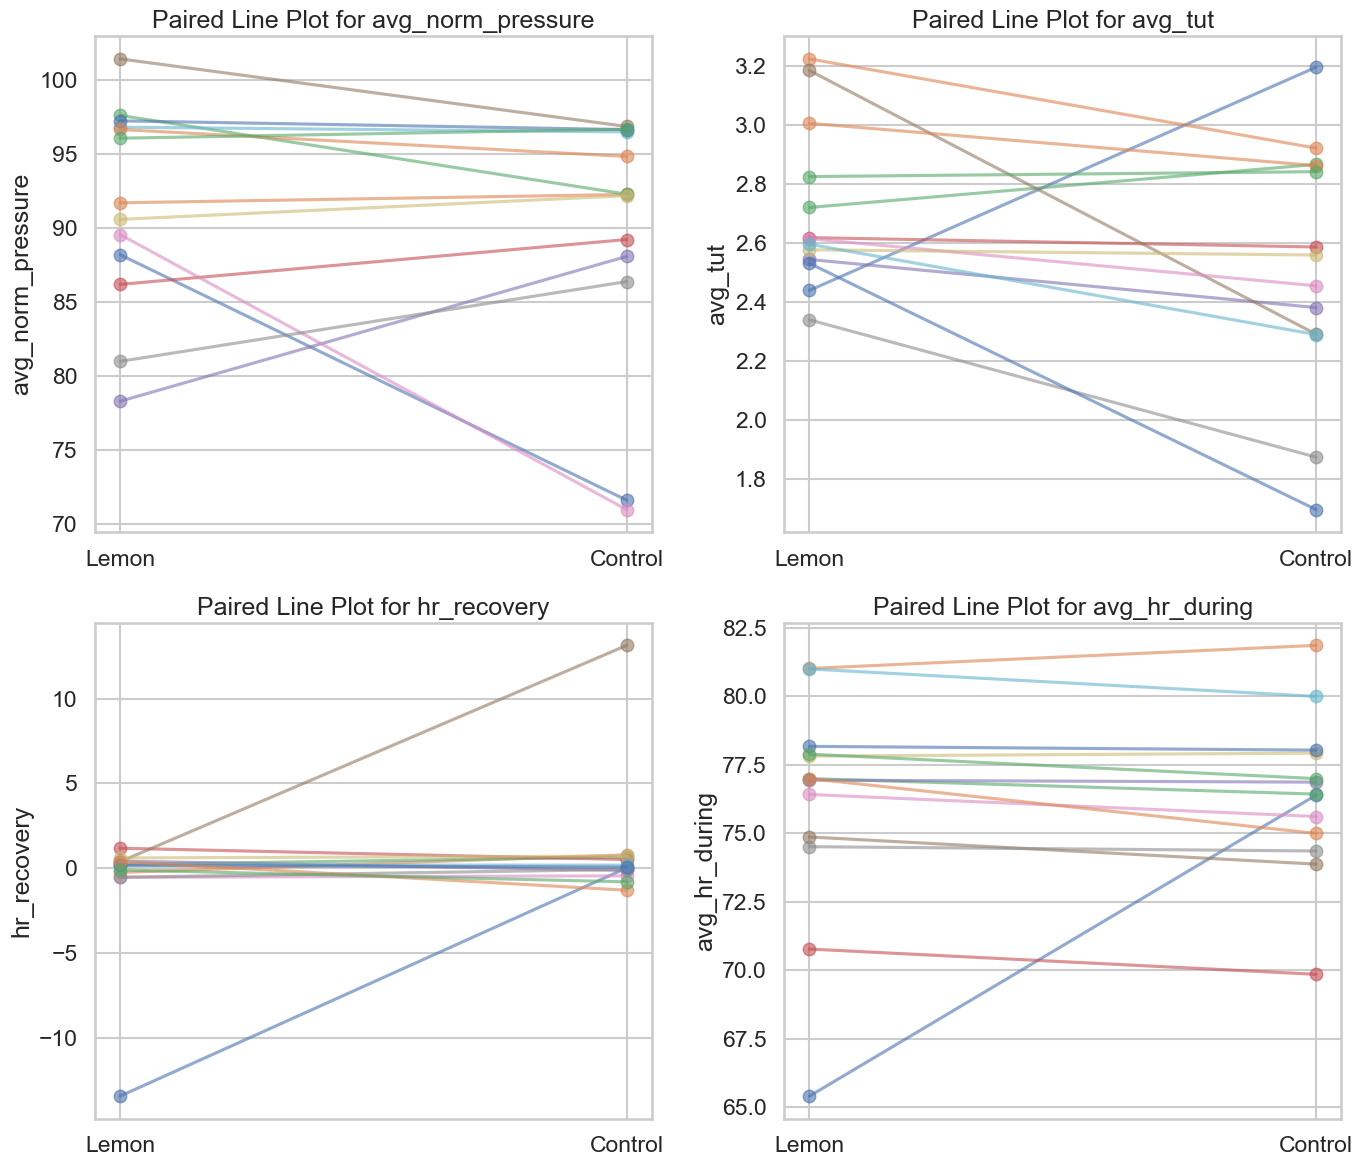

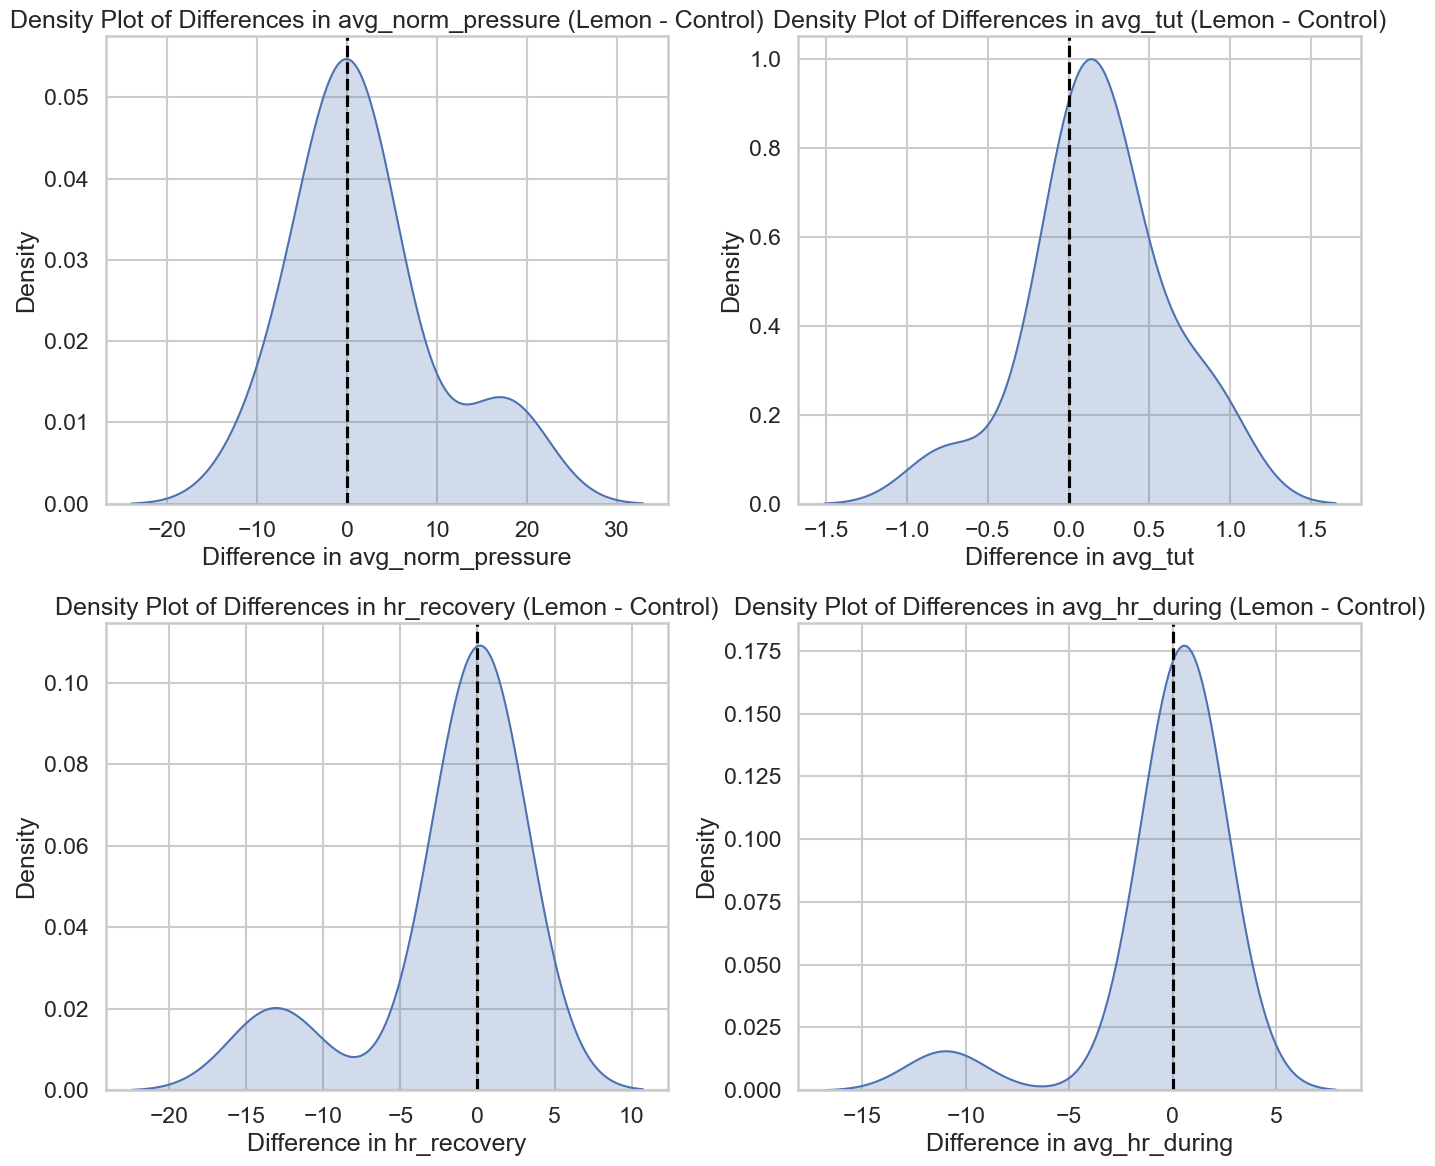

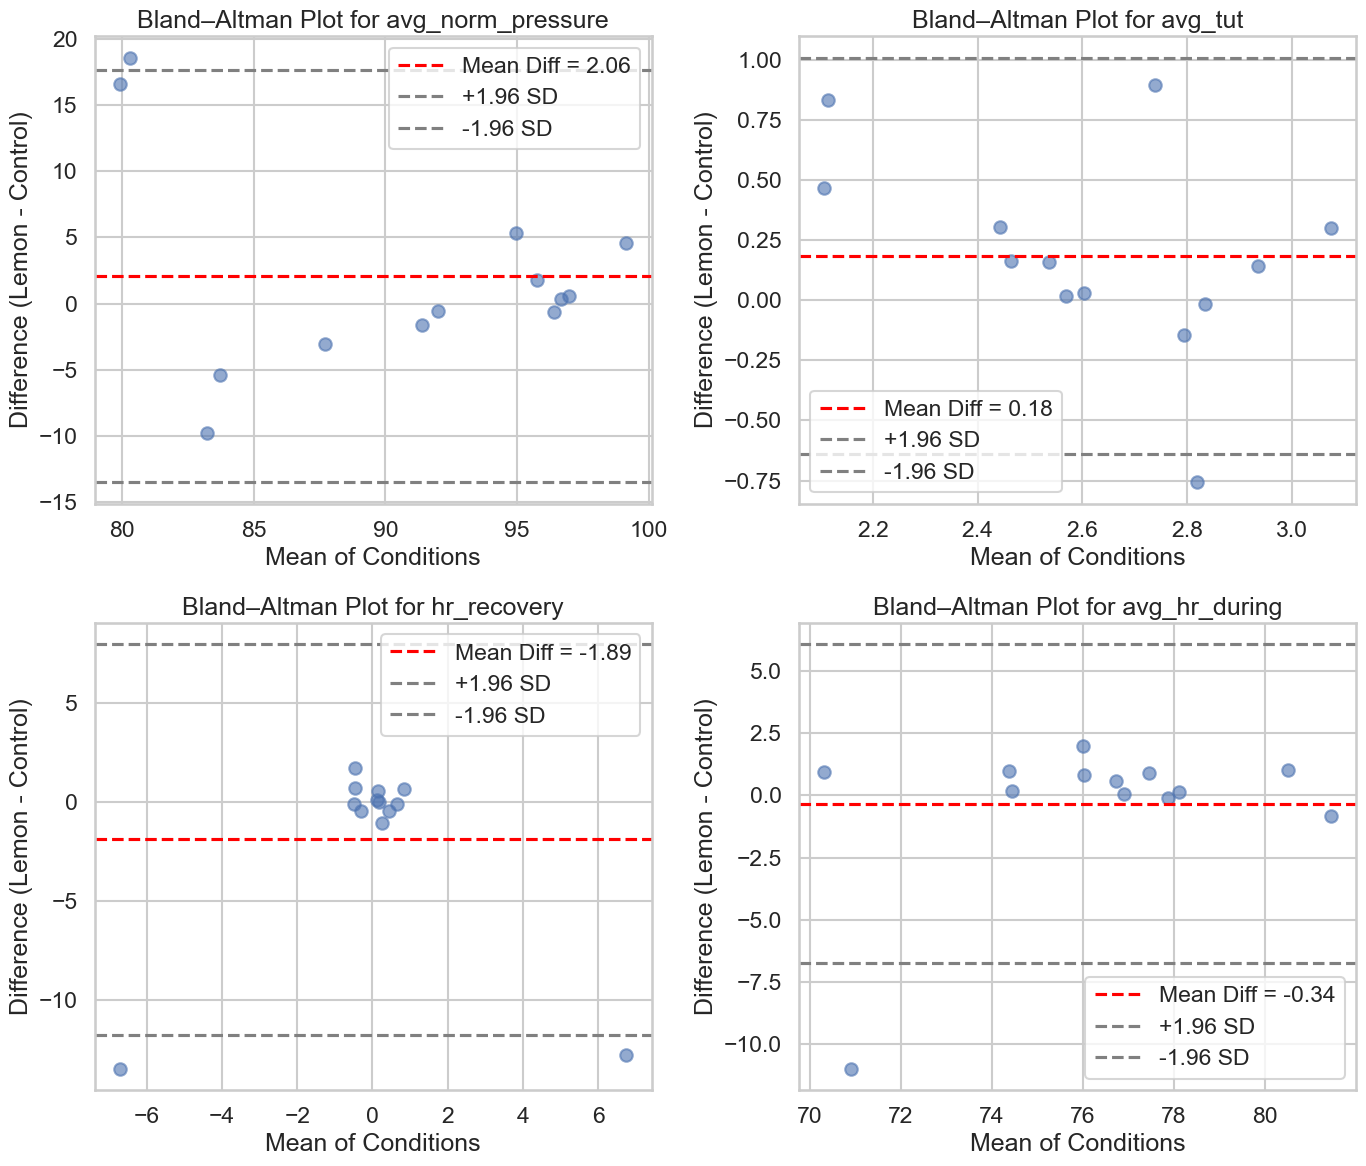

In [ ]:
# Extract data for each condition
Civet = pivot_data.xs('3', axis=1, level=1)
control = pivot_data.xs('4', axis=1, level=1)

# Compute paired differences (Civet - Control)
diffs = Civet - control
print('Mean Paired Differences (Civet - Control):')
print(diffs.mean())

### Paired Line Plots for Each Metric
# for metric in metrics:
#     plt.figure()
#     for user in Civet.index:
#         plt.plot(['Civet', 'Control'], [Civet.loc[user, metric], control.loc[user, metric]], '-o', alpha=0.6)
#     plt.title(f'Paired Line Plot for {metric}')
#     plt.ylabel(metric)
#     #plt.savefig(f'Q1Images/paired_line_plot_{metric}.png', bbox_inches='tight')
#     #plt.show()
#     # Save all paired line plots in one figure
fig, axes = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(14, 6 * (len(metrics) // 2 + len(metrics) % 2)))
axes = axes.flatten()
for i, metric in enumerate(metrics):
    ax = axes[i]
    for user in Civet.index:
        ax.plot(['Civet', 'Control'], [Civet.loc[user, metric], control.loc[user, metric]], '-o', alpha=0.6)
    ax.set_title(f'Paired Line Plot for {metric}')
    ax.set_ylabel(metric)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Civet', 'Control'])
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig('Q3Images/paired_line_plots_combined.png', bbox_inches='tight')
#plt.show()

### Density Plots of Differences
# Save all density plots in one figure
fig, axes = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(14, 6 * (len(metrics) // 2 + len(metrics) % 2)))
axes = axes.flatten()
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.kdeplot(diffs[metric].dropna(), shade=True, ax=ax)
    ax.set_title(f'Density Plot of Differences in {metric} (Civet - Control)')
    ax.set_xlabel(f'Difference in {metric}')
    ax.axvline(0, color='black', linestyle='--')
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig('Q3Images/density_plots_combined.png', bbox_inches='tight')
#plt.show()

### Bland–Altman Plot Function and Plot
def bland_altman_plot(data1, data2, metric_label, ax):
    mean_vals = np.mean([data1, data2], axis=0)
    diff_vals = data1 - data2
    md = np.mean(diff_vals)
    sd = np.std(diff_vals, ddof=1)
    
    ax.scatter(mean_vals, diff_vals, alpha=0.6)
    ax.axhline(md, color='red', linestyle='--', label=f'Mean Diff = {md:.2f}')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--', label=f'+1.96 SD')
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--', label=f'-1.96 SD')
    ax.set_xlabel('Mean of Conditions')
    ax.set_ylabel('Difference (Civet - Control)')
    ax.set_title(f'Bland–Altman Plot for {metric_label}')
    ax.legend()

# Save all Bland–Altman plots in a 2-column layout
fig, axes = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(14, 6 * (len(metrics) // 2 + len(metrics) % 2)))
axes = axes.flatten()
for i, metric in enumerate(metrics):
    bland_altman_plot(Civet[metric].dropna(), control[metric].dropna(), metric_label=metric, ax=axes[i])
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig('Q3Images/bland_altman_plots_combined.png', bbox_inches='tight')
#plt.show()

## 4. High–Level Statistical Analysis

In this section we perform a battery of advanced statistical tests on the paired differences between conditions. For each performance metric we:

- **Test for Normality:** Using the Shapiro–Wilk test on the differences.
- **Conduct a Paired t–Test:** Provided the differences are normally distributed.
- **Conduct a Wilcoxon Signed–Rank Test:** As a non–parametric alternative.
- **Calculate Effect Size (Cohen’s d):** To assess the magnitude of the difference.
- **Bootstrap Confidence Intervals:** To estimate robust confidence intervals for the mean difference.

We also perform a MANOVA on the vector of differences to assess their joint effect.

In [ ]:
def cohen_d(x, y):
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

def bootstrap_ci(data, n_boot=1000, ci=95):
    boot_means = []
    n = len(data)
    for i in range(n_boot):
        sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.nanmean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower, upper

results = {}
for metric in metrics:
    diff = Civet[metric].dropna() - control[metric].dropna()
    # Test for normality of differences
    sw_stat, sw_p = stats.shapiro(diff)
    # Paired t-test
    t_stat, t_p = stats.ttest_rel(Civet[metric].dropna(), control[metric].dropna())
    # Wilcoxon test
    try:
        w_stat, w_p = stats.wilcoxon(Civet[metric].dropna(), control[metric].dropna())
    except Exception as e:
        w_stat, w_p = np.nan, np.nan
    # Effect size calculation
    d_value = cohen_d(Civet[metric].dropna(), control[metric].dropna())
    # Bootstrap confidence interval
    lower_ci, upper_ci = bootstrap_ci(diff.values)
    
    results[metric] = {
        'Shapiro_p': sw_p,
        'Paired_t_stat': t_stat,
        'Paired_t_p': t_p,
        'Wilcoxon_stat': w_stat,
        'Wilcoxon_p': w_p,
        'Cohen_d': d_value,
        'Bootstrap_CI': (lower_ci, upper_ci)
    }

for metric, res in results.items():
    print(f"\nMetric: {metric}")
    for key, value in res.items():
        print(f"   {key}: {value}")

# MANOVA on the vector of differences
manova_df = pivot_data[[('avg_norm_pressure','3'), ('avg_norm_pressure','4'),
                         ('avg_tut','3'), ('avg_tut','4'),
                         ('hr_recovery','3'), ('hr_recovery','4')]].dropna()
manova_df.columns = ['norm_p_1', 'norm_p_4', 'tut_1', 'tut_4', 'hrrec_1', 'hrrec_4']
manova_df['diff_norm_p'] = manova_df['norm_p_1'] - manova_df['norm_p_4']
manova_df['diff_tut'] = manova_df['tut_1'] - manova_df['tut_4']
manova_df['diff_hrrec'] = manova_df['hrrec_1'] - manova_df['hrrec_4']

print("\nMANOVA on the differences:")
m = MANOVA.from_formula('diff_norm_p + diff_tut + diff_hrrec ~ 1', data=manova_df)
print(m.mv_test())


Metric: avg_norm_pressure
   Shapiro_p: 0.09318877338672002
   Paired_t_stat: 0.9373424954918013
   Paired_t_p: 0.3670650675632049
   Wilcoxon_stat: 39.0
   Wilcoxon_p: 0.684814453125
   Cohen_d: 0.259972033089774
   Bootstrap_CI: (-1.6805868089723304, 6.622832864138775)

Metric: avg_tut
   Shapiro_p: 0.365259632705049
   Paired_t_stat: 1.5825304439755876
   Paired_t_p: 0.13951357418966323
   Wilcoxon_stat: 17.0
   Wilcoxon_p: 0.0478515625
   Cohen_d: 0.43891497390282874
   Bootstrap_CI: (-0.033588501776002054, 0.38559421550671547)

Metric: hr_recovery
   Shapiro_p: 4.36690929971635e-05
   Paired_t_stat: -1.3601704279778037
   Paired_t_p: 0.19878051352365259
   Wilcoxon_stat: 40.0
   Wilcoxon_p: 0.7353515625
   Cohen_d: -0.3772434016495208
   Bootstrap_CI: (-4.893588445230517, 0.27736265802362775)

Metric: avg_hr_during
   Shapiro_p: 1.2133202461690226e-05
   Paired_t_stat: -0.3720628158187921
   Paired_t_p: 0.7163333489699938
   Wilcoxon_stat: 22.0
   Wilcoxon_p: 0.10986328125
   Coh

## 5. Model Diagnostics: Residual Analysis

We check the assumptions of our linear model on the difference in normalised max pressure with residual and Q–Q plots.

d:\anaconda\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


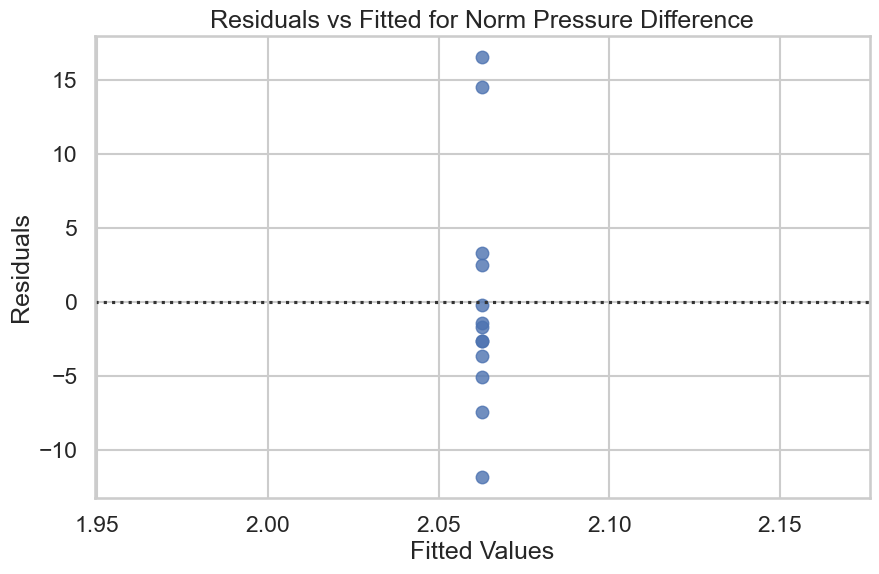

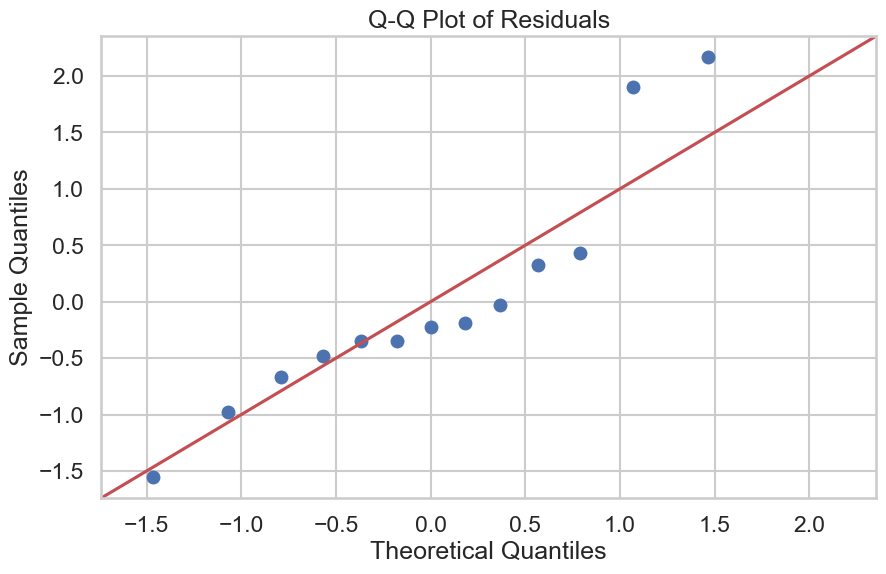

In [ ]:
# Fit a simple intercept-only model for the difference in normalised pressure
diff_norm = Civet['avg_norm_pressure'].dropna() - control['avg_norm_pressure'].dropna()
X = np.ones((len(diff_norm), 1))
model = sm.OLS(diff_norm, X).fit()

# Residual plot
residuals = model.resid
fitted = model.fittedvalues
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted for Norm Pressure Difference')
plt.savefig('Q3Images/residuals_norm_pressure.png', bbox_inches='tight')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.savefig('Q3Images/qqplot_residuals_norm_pressure.png', bbox_inches='tight')
plt.show()

## 6. Conclusions

In this focused analysis of RQ1 we have:

- **Extracted and computed** key performance metrics (normalised max pressure, average TUT, HR recovery) for each exercise session.
- **Isolated paired data** for the Civet (channel 1) and control (channel 4) conditions.
- Used a series of informative **visualisations** – paired line plots, density plots, and Bland–Altman plots – to showcase within–subject differences.
- Conducted a **battery of statistical tests** (paired t–test, Wilcoxon signed–rank test, effect size estimation, bootstrap confidence intervals, and MANOVA) that together provide high–level evidence on whether Civet improves performance compared to a no-scent condition.

These results, along with thorough model diagnostics, provide a robust, statistically high–level evaluation of RQ1. Further steps could include more sophisticated mixed–effects models or Bayesian inference to better capture individual variability.